1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [7]:
%matplotlib inline
import os
import sys
import re
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle

In [4]:
working = '../data/working'

In [5]:
stats_file = 'stats_bs_samples' # 'stats_samples'

In [127]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

In [128]:
print(stats_tpf['hyperparams'])

{u'pair': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95], u'edens': [1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65, 5.75, 5.8500000000000005, 5.95]}


In [130]:
np.linspace(1.05, 5.95, 50)

array([1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05,
       2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15,
       3.25, 3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25,
       4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35,
       5.45, 5.55, 5.65, 5.75, 5.85, 5.95])

In [131]:
stats_tpf.keys()

[u'function',
 'bcc_npt_langevin_3700K',
 'vac_npt_langevin_2000K',
 'inf',
 'relax',
 'screw_111_npt_langevin_2000K',
 u'hyperparams',
 'bcc_npt_langevin_300K',
 'eos_bcc',
 'eos',
 'fcc_npt_langevin_300K',
 'vacint',
 'eos_fcc',
 'i110_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'i111_npt_langevin_2000K',
 'bain']

In [136]:
stats_bspline = tpf_to_bsplines(stats_tpf)

len 50


(2.0, 5.86)

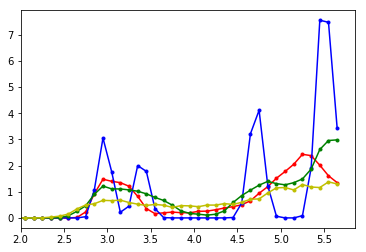

In [214]:
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.4, stats_bspline['liq_5000K']['energy'][0][2][:-3], 'y.-')
#plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3]), stats_bspline['eos']['energy'][2][2][:-3], 'c.-')
plt.xlim(2.0)


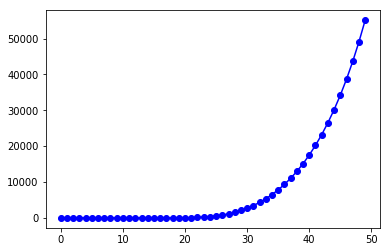

In [138]:
plt.plot(stats_tpf['relax']['energy'][0][2], 'bo-')

In [672]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [673]:
targets['eos']['box'] = targets['eos']['box'][4:9]
targets['eos']['xyz'] = targets['eos']['xyz'][4:9]
targets['eos']['temp'] = targets['eos']['temp'][4:9]
targets['eos']['beta'] = targets['eos']['beta'][4:9]
targets['eos']['energy'] = targets['eos']['energy'][4:9]
stats['eos']['energy'] = stats['eos']['energy'][4:9]

In [674]:
target['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats['relax']['energy'][1] = stats['inf']['energy'][0]

In [675]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0
targets['eos']['weight'] = 0.0
targets['eos_bcc']['weight'] = 0.0
targets['relax']['weight'] = 0.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
# targets['fcc_npt_langevin_300K']['weight'] = 0.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0



#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 0.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 0.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 0.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 0.0)]

In [676]:
pair_knots = [2.5648975, 2.629795, 2.6946925, 2.8663175, 2.973045,
              3.0797725, 3.5164725, 3.846445, 4.1764175, 4.700845,
              4.8953, 5.089755, 5.3429525,5.401695,5.4604375]

pair_knots = list(np.linspace(2.05, 5.25, 33))

#mb_knots = list(np.linspace(3.95, 5.25, 14))
mb_knots = list(np.linspace(3.75, 5.25, 16))

print(mb_knots)
print(pair_knots)
print(len(pair_knots))

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[2.05, 2.15, 2.25, 2.3499999999999996, 2.4499999999999997, 2.55, 2.65, 2.75, 2.8499999999999996, 2.9499999999999997, 3.05, 3.15, 3.25, 3.3499999999999996, 3.45, 3.55, 3.65, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
33


In [677]:
# Select knots for optimization
# cycle over knots of selected models

stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    #print(len(pair_knots), len(edens_knots), len(stats_bspline['hyperparams']['pair']))
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    #print(stats['hyperparams'])
#     stats_select_md = downselect(stats_md, pair_knots, edens_knots)
#     print(stats_select_md['hyperparams'])
#     stats['md'] = stats_select_md['md']
    stats_list.append(stats)

In [678]:
def make_matrices(target, stats, weights=False):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X = []
    # vector of dependent variable (configurational energies)
    y = []
    
    for key in target:
        
        # eliminate trajectories with 0 weight
        if weights:
            if target[key]['weight'] == 0.0:
                continue

        for i, (config, energy) in enumerate(zip(stats[key]['energy'], target[key]['energy'])):
            # add energy
            y.append(energy)
            
            # create an array of independent variables
            x_vars = [config[0][0], config[1][0]] # embedding
            #print('x_vars', x_vars, key, i, stats[key]['energy'][0][0], stats[key]['energy'][1][0])
            #print('x_vars', x_vars, stats[key]['energy'][0][0], stats[key]['energy'][1][0])

            #print('config[2]', config[2])
            x_vars += list(config[2])                   # pair interaction b-spline stats
            X.append(x_vars)
    
    return np.array(X), np.array(y)

In [679]:
def tpf(r, rc):
    return (rc-r)**3 if r < rc else 0.0

In [680]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]
def make_bspline(coeffs, k, r):
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            u += c*b*tpf(r, k[i+j])
        
    return u

In [681]:
print(pair_knots), X.shape

[2.05, 2.15, 2.25, 2.3499999999999996, 2.4499999999999997, 2.55, 2.65, 2.75, 2.8499999999999996, 2.9499999999999997, 3.05, 3.15, 3.25, 3.3499999999999996, 3.45, 3.55, 3.65, 3.75, 3.8499999999999996, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25] (559, 35)


(2.0, 5.65)

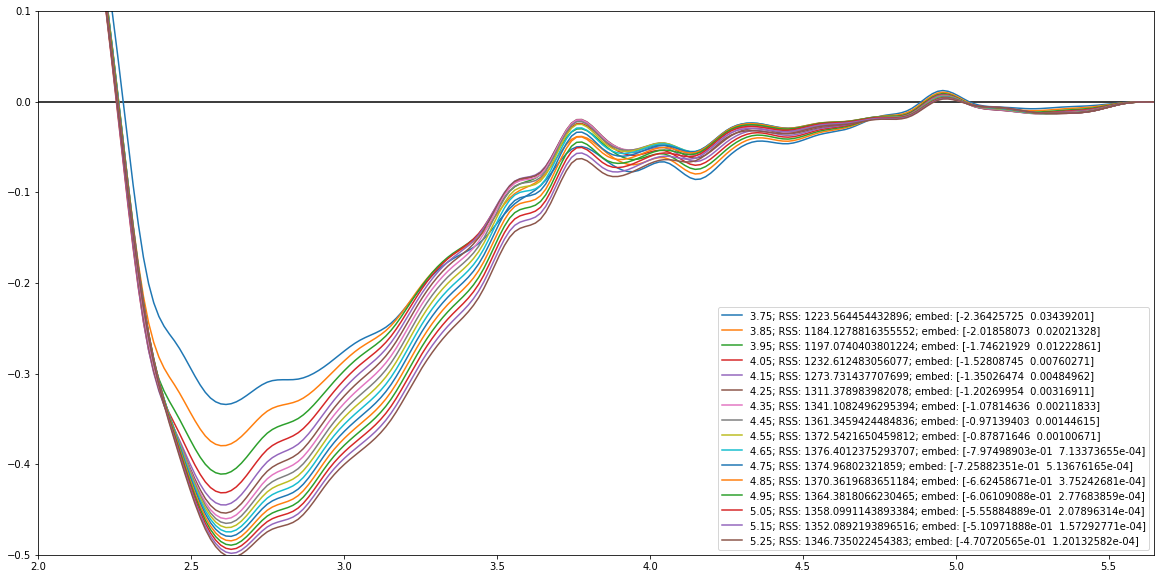

In [682]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[:]):
#     if i != 1:
#         continue
    X, y = make_matrices(targets, stat, weights=True)
    #print(X.shape, y.shape)
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    rss = (y - X.dot(beta)).T.dot(y - X.dot(beta))
    label_str = str(round(stat['hyperparams']['edens'][0], 2))
    label_str += '; RSS: ' + str(rss)
    label_str += '; embed: ' + str(beta[:2])
    #plt.plot(np.array(pair_knots)+0.2, beta[2:], label=label_str)
    
    rr = np.linspace(1.5, 5.7, 250)
    coeffs = [2000, 500, 100., 50.] + list(beta[2:])
    knots = [1.65, 1.75, 1.85, 1.95] + pair_knots +[5.35, 5.45, 5.55, 5.65]
    #bs = [180*make_bspline(beta[2:], pair_knots+[5.35, 5.45, 5.55, 5.65], r) for r in rr]
    bs = [make_bspline(coeffs, knots, r) for r in rr]

    plt.plot(rr, bs, label=label_str)
    
    betas.append(beta)


plt.hlines(0,1,6)
plt.legend(loc='lower right')
plt.ylim(-100,2000)
plt.ylim(-0.5,0.1)
plt.xlim(2.0,5.65)

(2.0, 5.5)

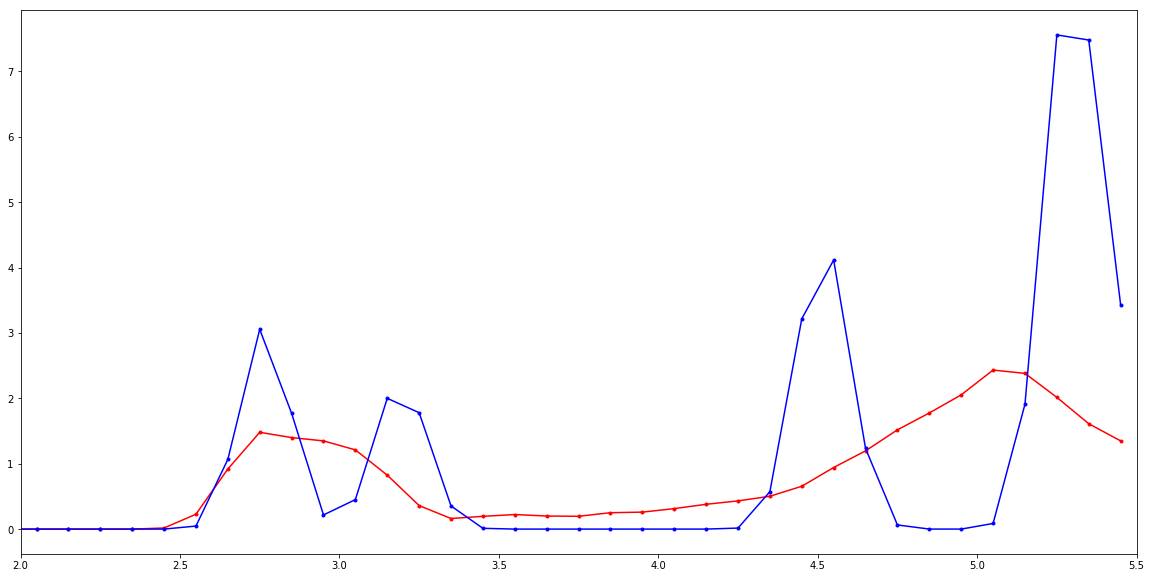

In [683]:
plt.figure(figsize=(20,10))
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['fcc_npt_langevin_300K']['energy'][0][2][:-3], 'r.-')
plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['bcc_npt_langevin_300K']['energy'][0][2][:-3], 'b.-')
# plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['bcc_npt_langevin_3700K']['energy'][0][2][:-3], 'g.-')
# plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-3])+0.2, stats_bspline['liq_5000K']['energy'][0][2][:-3], 'y.-')
#plt.plot(np.array(stats_bspline['hyperparams']['pair'][:-4-3]), stats_bspline['eos']['energy'][2][2][:-3], 'c.-')
plt.xlim(2.0,5.5)


In [684]:
def penalty_matrix(n, order):
    
    pen ={2:[1.0, -2.0, 1.0],
          3:[1.0, -3.0, 3.0, -1.0]}
    
    D = np.zeros((n-2-order, n), dtype=float)
    
    for i in range(n-2-order):
        D[i, 2+i:2+i+1+order] = pen[order]

    return D

In [685]:
D = penalty_matrix(X.shape[1], 3)
Dsqr = D.T.dot(D)
print(Dsqr)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   1. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  19. -12.   3.]
 [  0.   0.   0. ... -12.  10.  -3.]
 [  0.   0.   0. ...   3.  -3.   1.]]


(2.0, 5.65)

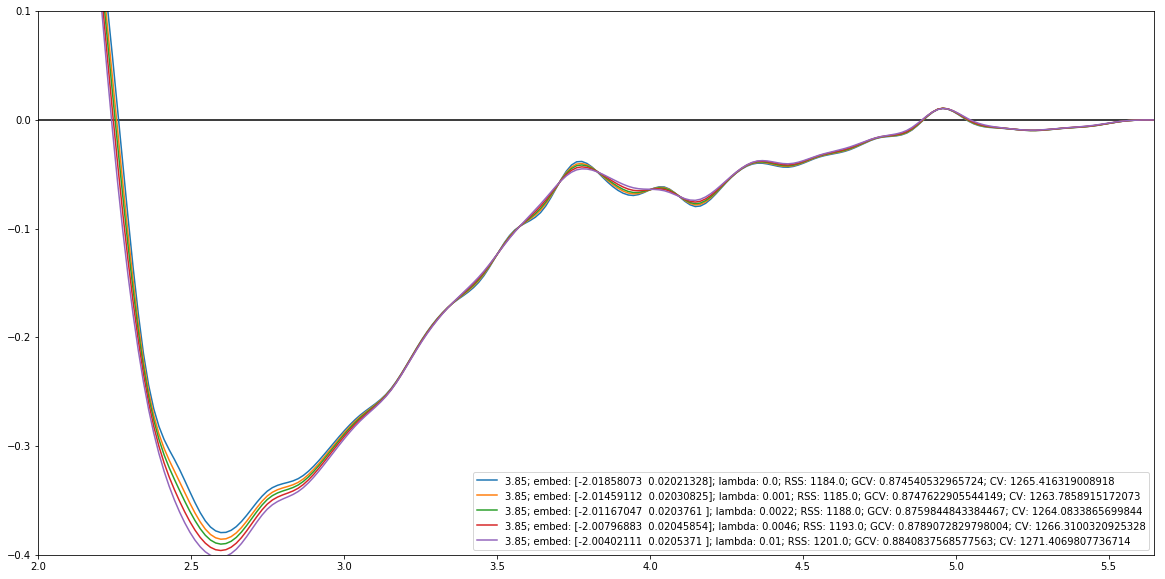

In [686]:
plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[1:2]):
#     if i != 1:
#         continue
    for lamb in [0.0] + list(np.logspace(-3, -2, 4)):
        X, y = make_matrices(targets, stat, weights=True)
    #print(X.shape, y.shape)
        beta = np.linalg.inv(X.T.dot(X) + lamb*Dsqr).dot(X.T).dot(y)
        
        
        rss = (y - X.dot(beta)).T.dot(y - X.dot(beta))
        label_str = str(round(stat['hyperparams']['edens'][0], 2))
        label_str += '; embed: ' + str(beta[:2])
        label_str += '; lambda: ' + str(round(lamb, 4))
        label_str += '; RSS: ' + str(round(rss, 0))
        
        hat = X.dot(np.linalg.inv(X.T.dot(X) + lamb*Dsqr)).dot(X.T)
        hat_trace = np.trace(hat)
        gcv = (y - X.dot(beta)).T.dot(y - X.dot(beta))/(X.shape[0] - hat_trace)
        label_str += '; GCV: ' + str(gcv)#str(round(gcv, 0))
        
        vec = (y - X.dot(beta))/(1. - np.diag(hat))
        cv = vec.T.dot(vec)
        
        label_str += '; CV: ' + str(cv)#str(round(gcv, 0))


    #plt.plot(np.array(pair_knots)+0.2, beta[2:], label=label_str)
    
        rr = np.linspace(1.5, 5.7, 250)
        coeffs = [2000, 500, 100., 50.] + list(beta[2:])
        knots = [1.65, 1.75, 1.85, 1.95] + pair_knots +[5.35, 5.45, 5.55, 5.65]
    #bs = [180*make_bspline(beta[2:], pair_knots+[5.35, 5.45, 5.55, 5.65], r) for r in rr]
        bs = [make_bspline(coeffs, knots, r) for r in rr]

        plt.plot(rr, bs, label=label_str)
    
        betas.append(beta)


plt.hlines(0,1,6)
plt.legend(loc='lower right')
plt.ylim(-100,2000)
plt.ylim(-0.4,0.1)
plt.xlim(2.0,5.65)